In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer
import seaborn as sns


In [67]:
domains = pd.read_csv('train.csv', index_col=0)
domains.head()

category     clicks     likes  buys  4xx_errors  5xx_errors  \
6622                ecom  6488536.0       NaN     0       82221           0   
2047  information_source   874840.0   21100.0     0       12872           0   
1118  information_source   571210.0   94707.0     0           0        7420   
4992                news    89534.0     924.0     0         834           0   
9970  information_source  1043953.0  289288.0     0       58375       20260   

     complaints_count  average_dwelltime  source_attractiveness  \
6622                0          18.450527               0.461750   
2047                0          10.721619              -0.022317   
1118                0           1.922243               0.046396   
4992                0           2.149243              -0.093360   
9970             3948           3.764965               0.027303   

               date_of_registration  
6622  2020-04-21 16:04:41.817367072  
2047  2024-07-19 23:50:07.268931816  
1118  2024-07-13 16:35:54.794883135  
4992  2024-09-10 21:29:14.006315095  
9970  2024-05-26 11:07:15.950527838

In [68]:
domains.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 6622 to 9289
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               8000 non-null   object 
 1   clicks                 7727 non-null   float64
 2   likes                  7624 non-null   float64
 3   buys                   8000 non-null   int64  
 4   4xx_errors             8000 non-null   int64  
 5   5xx_errors             8000 non-null   int64  
 6   complaints_count       7527 non-null   object 
 7   average_dwelltime      8000 non-null   float64
 8   source_attractiveness  8000 non-null   float64
 9   date_of_registration   8000 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 687.5+ KB


In [69]:
target = 'source_attractiveness'

In [70]:
domains['date_of_registration'] = pd.to_datetime(domains['date_of_registration'])
print(domains['date_of_registration'].max())

2024-09-29 19:18:45.569391241


In [71]:
last_date = pd.Timestamp('2024-09-30')
domains['age'] = (last_date - domains['date_of_registration']) / pd.Timedelta(days=365)
domains = domains.drop(columns='date_of_registration')
domains['age'].describe()

count    8000.000000
mean        2.005641
std         2.025067
min         0.000535
25%         0.585100
50%         1.381715
75%         2.743200
max        17.726856
Name: age, dtype: float64

In [72]:
na_values = np.array([x for x in domains['complaints_count'] if type(x) is not str or not x.isdigit()])
unique, counts = np.unique(na_values, return_counts=True)
for x, y in zip(unique, counts):
    print(f'{x}: {y}')

-: 411
nan: 473


In [73]:
domains.loc[domains['complaints_count'] == '-', 'complaints_count'] = float('nan')
domains['complaints_count'] = domains['complaints_count'].astype(float)


In [74]:
domains.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 6622 to 9289
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               8000 non-null   object 
 1   clicks                 7727 non-null   float64
 2   likes                  7624 non-null   float64
 3   buys                   8000 non-null   int64  
 4   4xx_errors             8000 non-null   int64  
 5   5xx_errors             8000 non-null   int64  
 6   complaints_count       7116 non-null   float64
 7   average_dwelltime      8000 non-null   float64
 8   source_attractiveness  8000 non-null   float64
 9   age                    8000 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 687.5+ KB


In [75]:
real_features = ['clicks', 'likes', 'buys', '4xx_errors', '5xx_errors', 'complaints_count', 'average_dwelltime', 'age']

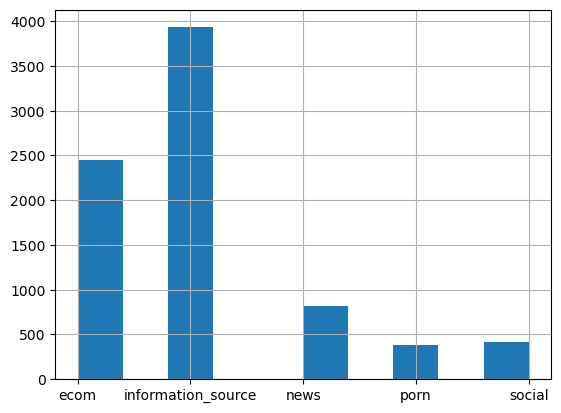

In [76]:
domains['category'].hist()
plt.show()

In [77]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_category_matrix = encoder.fit_transform(domains[['category']])

In [78]:
categorial_features = encoder.categories_[0]
categorial_features

array(['ecom', 'information_source', 'news', 'porn', 'social'],
      dtype=object)

In [79]:
one_hot_df = pd.DataFrame(one_hot_category_matrix, columns=categorial_features, index=domains.index, dtype=int)
domains = domains.join(one_hot_df)
domains.head()

category     clicks     likes  buys  4xx_errors  5xx_errors  \
6622                ecom  6488536.0       NaN     0       82221           0   
2047  information_source   874840.0   21100.0     0       12872           0   
1118  information_source   571210.0   94707.0     0           0        7420   
4992                news    89534.0     924.0     0         834           0   
9970  information_source  1043953.0  289288.0     0       58375       20260   

      complaints_count  average_dwelltime  source_attractiveness       age  \
6622               0.0          18.450527               0.461750  4.444740   
2047               0.0          10.721619              -0.022317  0.197279   
1118               0.0           1.922243               0.046396  0.214544   
4992               0.0           2.149243              -0.093360  0.052342   
9970            3948.0           3.764965               0.027303  0.346676   

      ecom  information_source  news  porn  social  
6622     1                   0     0     0       0  
2047     0                   1     0     0       0  
1118     0                   1     0     0       0  
4992     0                   0     1     0       0  
9970     0                   1     0     0       0

In [80]:
for feature in real_features:
    print(f'Negative {feature} count: {domains[domains[feature] < 0].shape[0]}')


Negative clicks count: 0
Negative likes count: 0
Negative buys count: 0
Negative 4xx_errors count: 0
Negative 5xx_errors count: 0
Negative complaints_count count: 0
Negative average_dwelltime count: 407
Negative age count: 0


In [81]:
domains.loc[domains['average_dwelltime'] < 0, 'average_dwelltime'] = float('nan')
domains.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 6622 to 9289
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               8000 non-null   object 
 1   clicks                 7727 non-null   float64
 2   likes                  7624 non-null   float64
 3   buys                   8000 non-null   int64  
 4   4xx_errors             8000 non-null   int64  
 5   5xx_errors             8000 non-null   int64  
 6   complaints_count       7116 non-null   float64
 7   average_dwelltime      7593 non-null   float64
 8   source_attractiveness  8000 non-null   float64
 9   age                    8000 non-null   float64
 10  ecom                   8000 non-null   int64  
 11  information_source     8000 non-null   int64  
 12  news                   8000 non-null   int64  
 13  porn                   8000 non-null   int64  
 14  social                 8000 non-null   int64  
dtypes: flo

In [82]:
domains.head()

category     clicks     likes  buys  4xx_errors  5xx_errors  \
6622                ecom  6488536.0       NaN     0       82221           0   
2047  information_source   874840.0   21100.0     0       12872           0   
1118  information_source   571210.0   94707.0     0           0        7420   
4992                news    89534.0     924.0     0         834           0   
9970  information_source  1043953.0  289288.0     0       58375       20260   

      complaints_count  average_dwelltime  source_attractiveness       age  \
6622               0.0          18.450527               0.461750  4.444740   
2047               0.0          10.721619              -0.022317  0.197279   
1118               0.0           1.922243               0.046396  0.214544   
4992               0.0           2.149243              -0.093360  0.052342   
9970            3948.0           3.764965               0.027303  0.346676   

      ecom  information_source  news  porn  social  
6622     1                   0     0     0       0  
2047     0                   1     0     0       0  
1118     0                   1     0     0       0  
4992     0                   0     1     0       0  
9970     0                   1     0     0       0

In [83]:
domains.describe()

clicks         likes          buys    4xx_errors    5xx_errors  \
count  7.727000e+03  7.624000e+03  8.000000e+03  8.000000e+03  8.000000e+03   
mean   2.749785e+06  5.985027e+05  5.810509e+05  8.204958e+04  2.769224e+04   
std    4.699120e+06  1.978345e+06  2.262221e+06  1.555219e+05  7.946935e+04   
min    5.100000e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.599210e+05  0.000000e+00  0.000000e+00  2.943000e+03  0.000000e+00   
50%    1.097221e+06  3.399550e+04  0.000000e+00  2.671750e+04  0.000000e+00   
75%    2.915358e+06  2.860638e+05  0.000000e+00  9.500225e+04  2.016375e+04   
max    6.203206e+07  5.582181e+07  4.277391e+07  2.904996e+06  1.865588e+06   

       complaints_count  average_dwelltime  source_attractiveness  \
count       7116.000000        7593.000000            8000.000000   
mean        6418.338252           7.407269               0.191997   
std        16082.069321          10.092981               0.227873   
min            0.000000           0.000997              -0.681718   
25%          144.500000           1.837982               0.038220   
50%         1393.000000           4.384810               0.154256   
75%         5099.750000           9.276874               0.282510   
max       402119.000000         211.218066               1.355736   

               age         ecom  information_source         news         porn  \
count  8000.000000  8000.000000         8000.000000  8000.000000  8000.000000   
mean      2.005641     0.306500            0.491750     0.102000     0.047875   
std       2.025067     0.461069            0.499963     0.302667     0.213515   
min       0.000535     0.000000            0.000000     0.000000     0.000000   
25%       0.585100     0.000000            0.000000     0.000000     0.000000   
50%       1.381715     0.000000            0.000000     0.000000     0.000000   
75%       2.743200     1.000000            1.000000     0.000000     0.000000   
max      17.726856     1.000000            1.000000     1.000000     1.000000   

            social  
count  8000.000000  
mean      0.051875  
std       0.221788  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

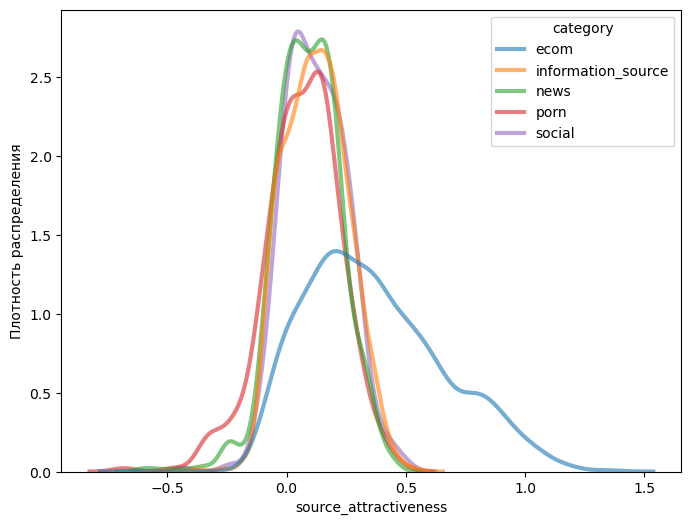

In [84]:
X = domains[target]
y = domains['category']

fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(x=X, hue=y, ax=ax, common_norm=False, lw=3, alpha=0.6)

ax.set_xlabel(target)
ax.set_ylabel('Плотность распределения')

plt.show()

Так как для ecom распределение таргета сильно отличается от остальных категорий, и фича buys используется только в этой категории, разделим датасет и будем обучать 2 модели

In [85]:
ecom = domains[domains['ecom'] == 1].drop(columns=['category', *categorial_features])
other_domains = domains[domains['ecom'] == 0].drop(columns=['ecom', 'buys'])
print(ecom.info())
print(other_domains.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2452 entries, 6622 to 9289
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   clicks                 2360 non-null   float64
 1   likes                  2336 non-null   float64
 2   buys                   2452 non-null   int64  
 3   4xx_errors             2452 non-null   int64  
 4   5xx_errors             2452 non-null   int64  
 5   complaints_count       2152 non-null   float64
 6   average_dwelltime      2324 non-null   float64
 7   source_attractiveness  2452 non-null   float64
 8   age                    2452 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 191.6 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 5548 entries, 2047 to 1231
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   category               5548 non-null   object 
 1   c

In [21]:
import warnings
warnings.filterwarnings('ignore')

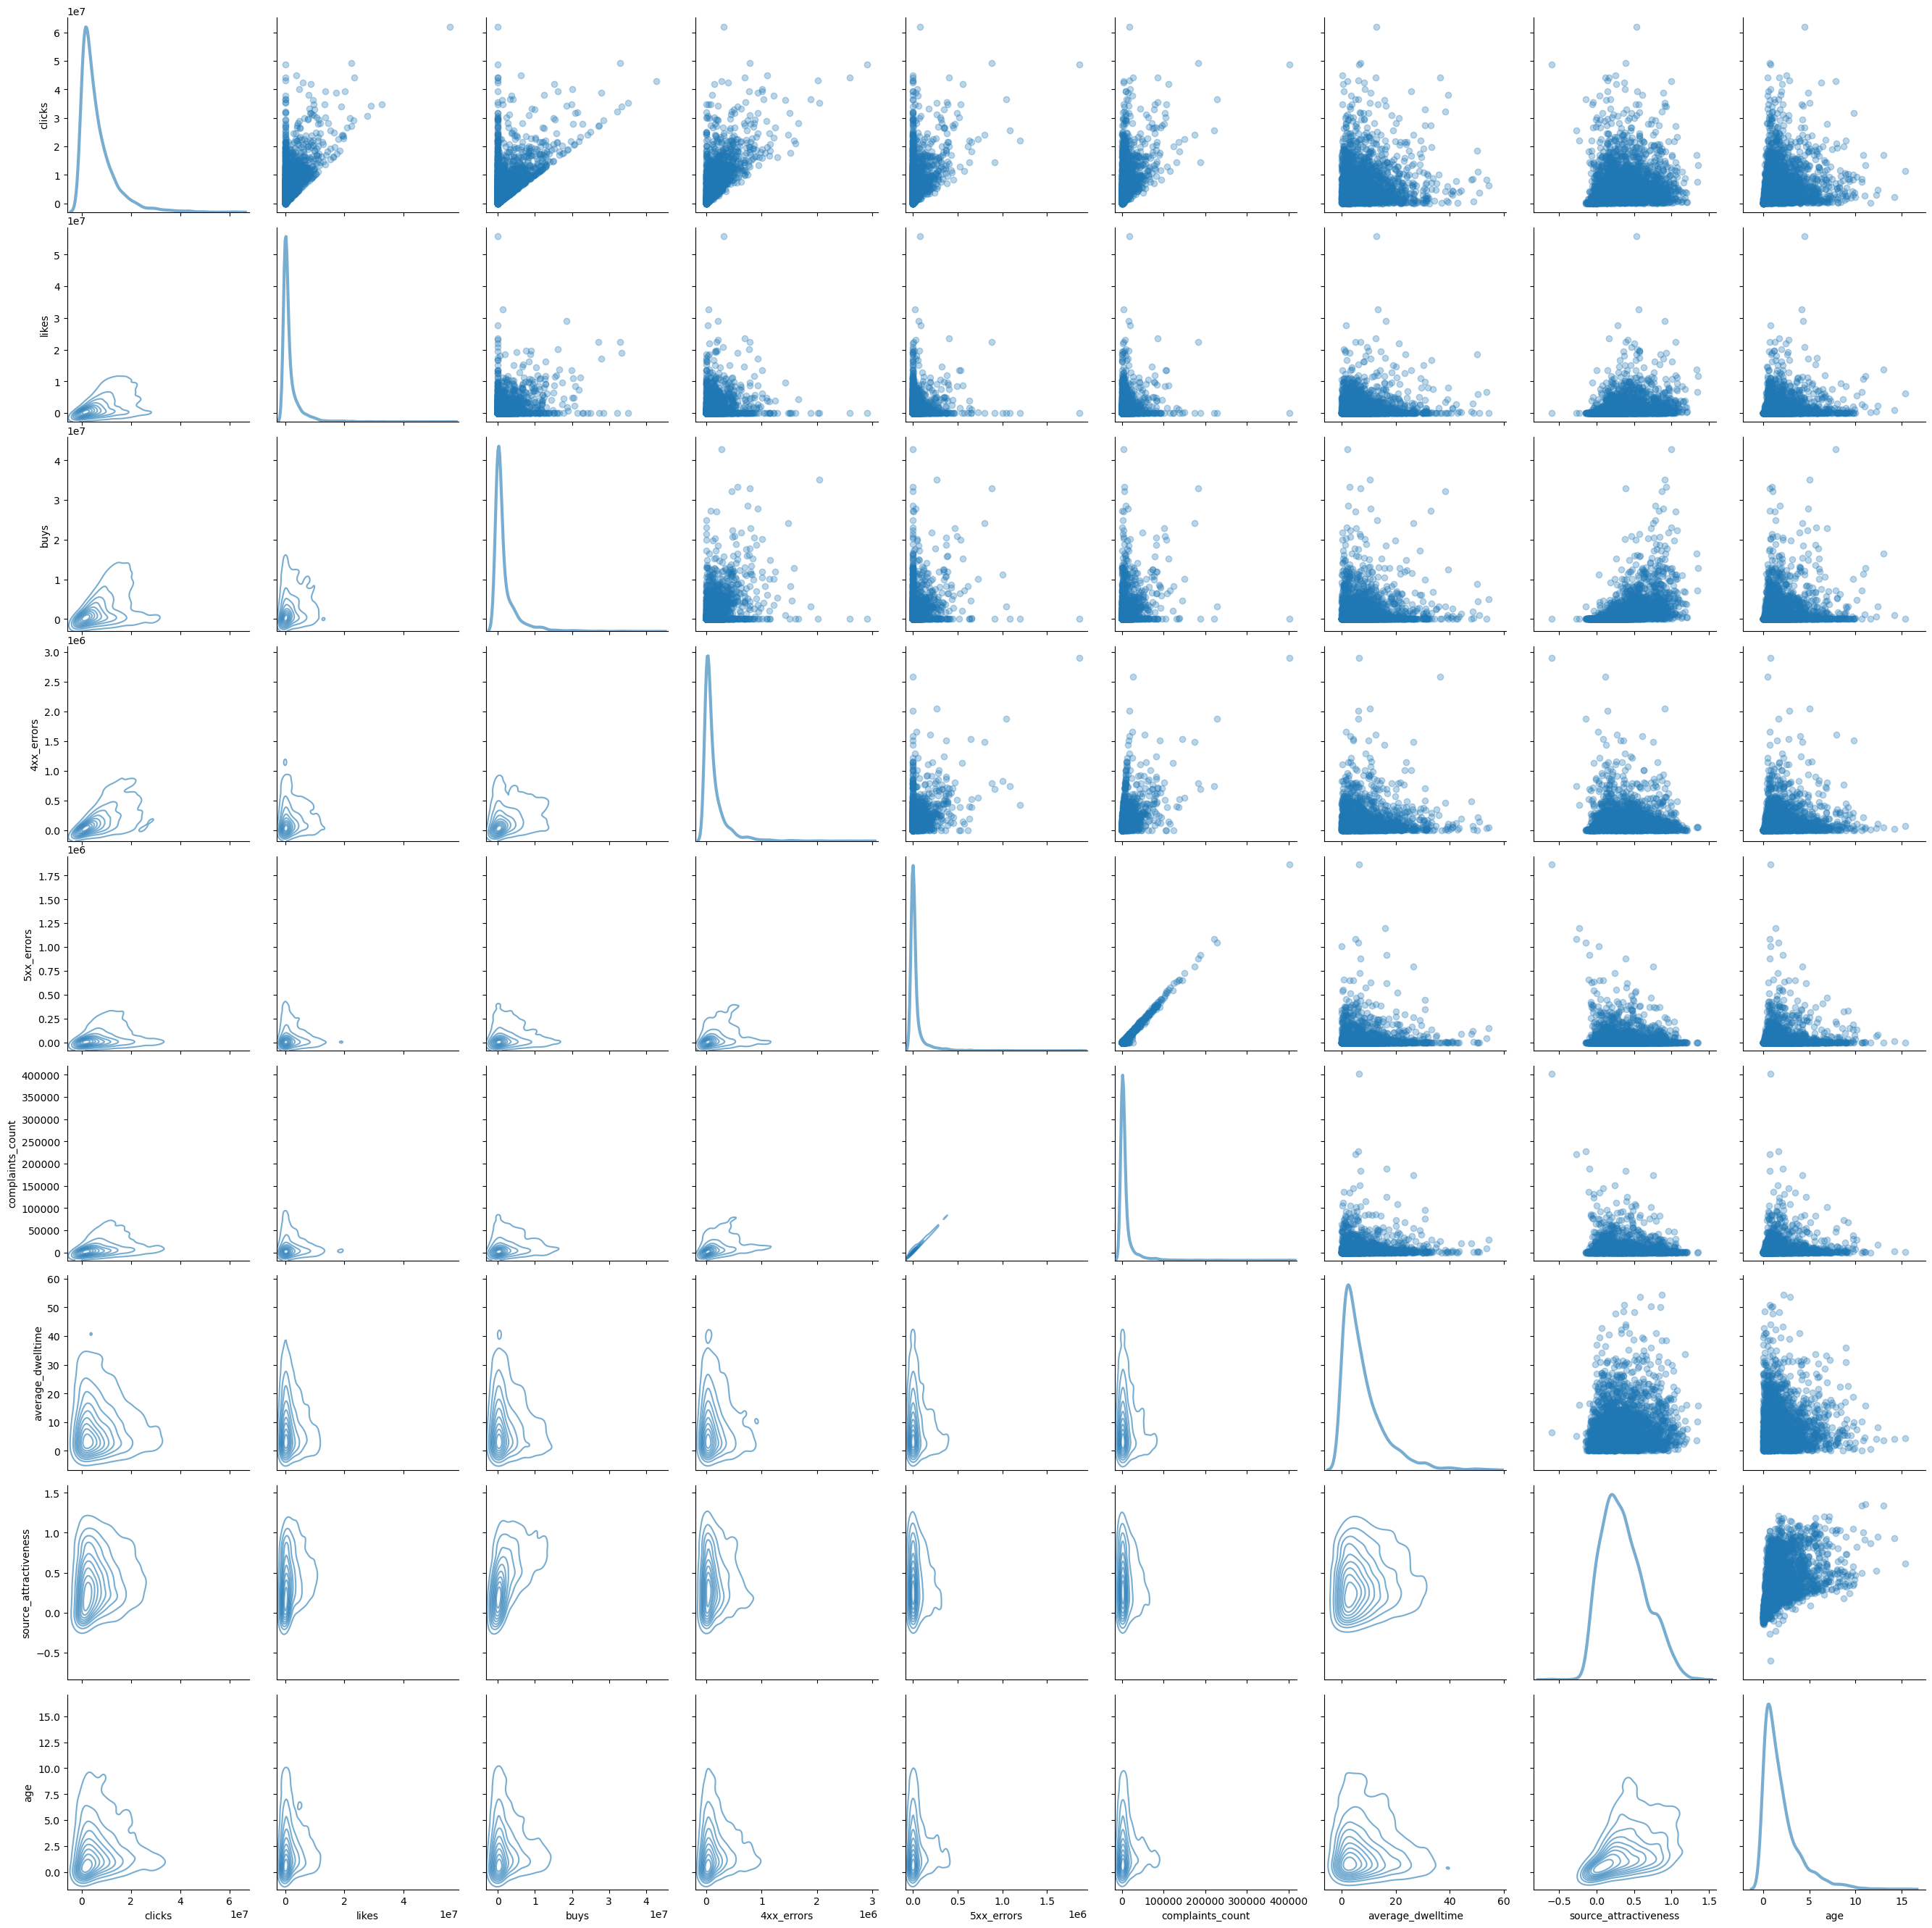

In [22]:
g = sns.PairGrid(ecom, diag_sharey=False, height=3)
g.map_lower(sns.kdeplot, alpha=0.6)
g.map_upper(plt.scatter, alpha=0.3)
g.map_diag(sns.kdeplot, lw=3, alpha=0.6, common_norm=False)
plt.show()

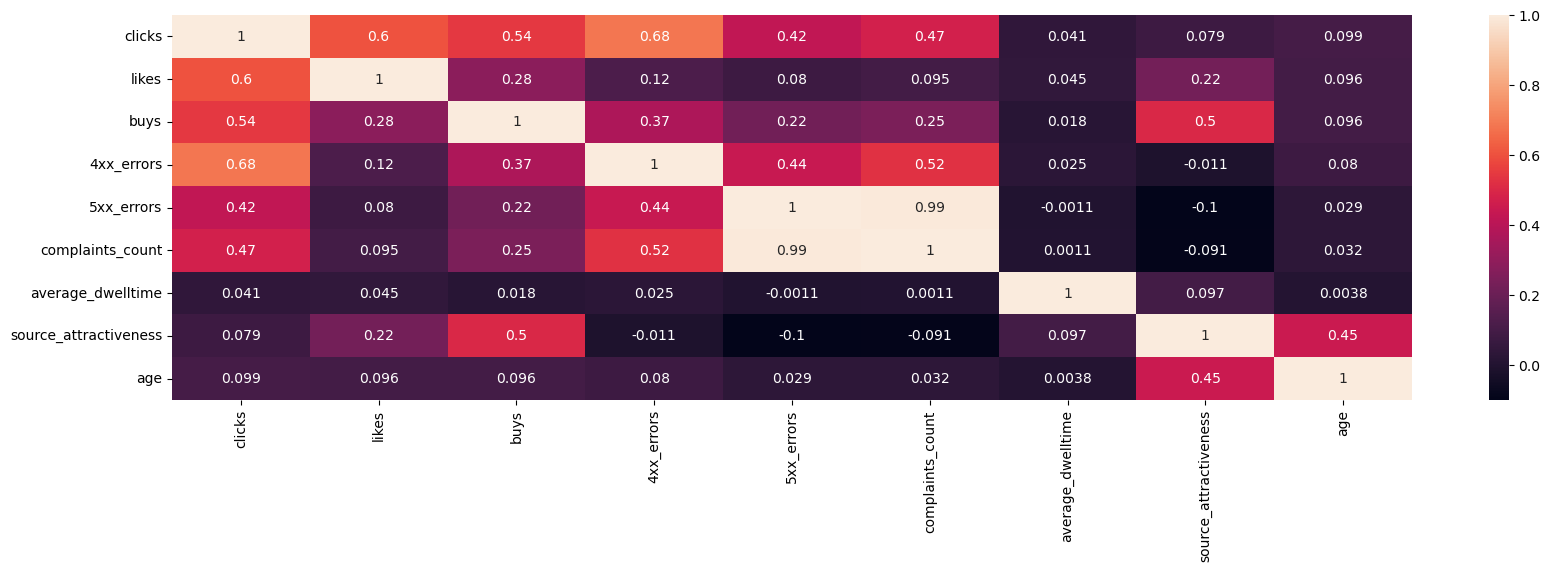

In [86]:
corr_matrix = ecom.corr()
plt.figure(figsize=(20, 5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

Так как признаки с пропусками не сильно коррелируют с таргетом, заменим их медианным значением, а complaints_count уберем, так как он линейно зависим с 5xx_errors

In [87]:
ecom['clicks'] = ecom['clicks'].fillna(ecom['clicks'].median())
ecom['likes'] = ecom['likes'].fillna(ecom['likes'].median())
ecom['average_dwelltime'] = ecom['average_dwelltime'].fillna(ecom['average_dwelltime'].median())
# ecom.dropna(inplace=True)
ecom.drop(columns='complaints_count', inplace=True)
ecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2452 entries, 6622 to 9289
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   clicks                 2452 non-null   float64
 1   likes                  2452 non-null   float64
 2   buys                   2452 non-null   int64  
 3   4xx_errors             2452 non-null   int64  
 4   5xx_errors             2452 non-null   int64  
 5   average_dwelltime      2452 non-null   float64
 6   source_attractiveness  2452 non-null   float64
 7   age                    2452 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 172.4 KB


Попробуем нагенерировать новые фичи. 
Те признаки, которые не коррелируют с таргетом, были удалены.

In [88]:
def get_per_year(df, feature):
    return df[feature] / df['age']

def get_per_click(df, feature):
    return df[feature] / df['clicks']

def get_per_dwelltime(df, feature):
    return df[feature] / df['average_dwelltime']

In [89]:
for i in ecom.drop(columns=[target, 'age', 'average_dwelltime']):
    ecom[f'{i}_per_year'] = get_per_year(ecom, i)

<Axes: >

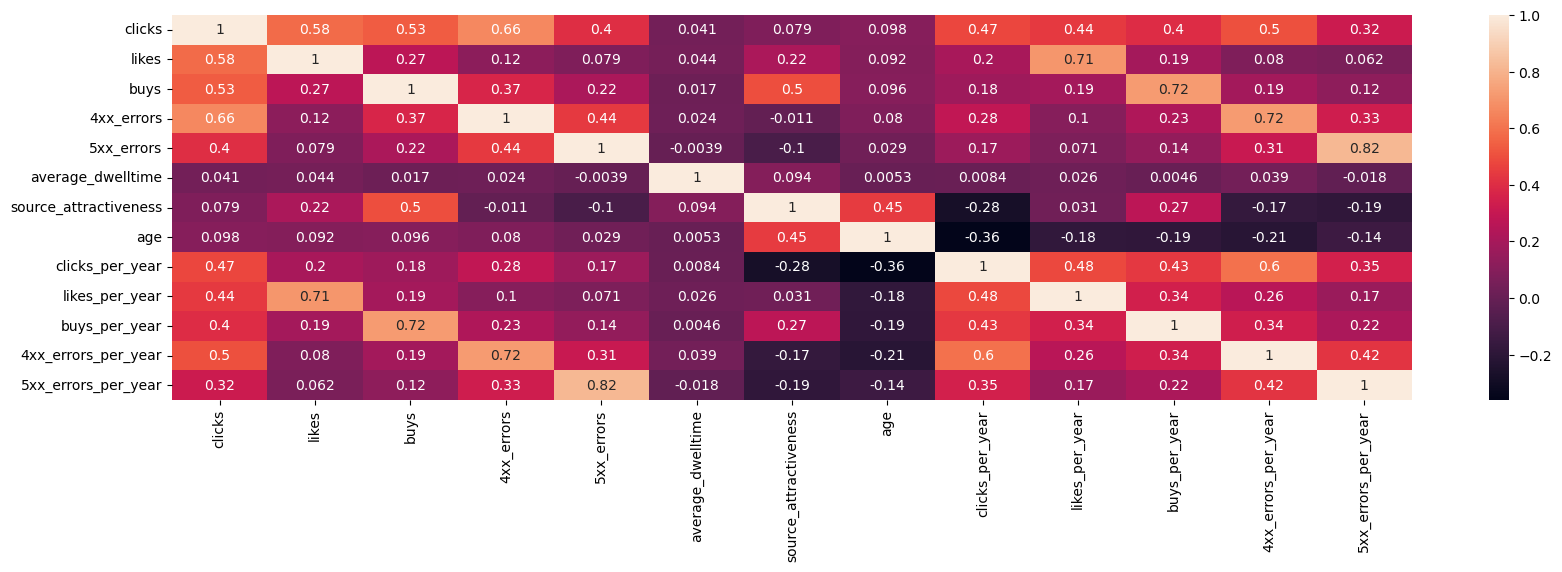

In [90]:
corr = ecom.corr()
plt.figure(figsize=(20, 5))
sns.heatmap(corr, annot=True)

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(ecom.drop(columns=target), ecom[target], test_size=0.2)

ecom_scaler = StandardScaler()
X_train = ecom_scaler.fit_transform(X_train)
X_test = ecom_scaler.transform(X_test)

In [92]:
alphas = np.logspace(-1, 5)
l1_ratio = np.logspace(-1, 0)

In [93]:
ecom_model = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas)

ecom_model.fit(X_train, Y_train)

print('Alpha:', ecom_model.alpha_)
print('L1-ratio:', ecom_model.l1_ratio_)

Y_pred = ecom_model.predict(X_test)
print('MSE:', mean_squared_error(Y_test, Y_pred))
print('MAPE:', mean_absolute_percentage_error(Y_test, Y_pred))
print('R2-score', r2_score(Y_test, Y_pred))

Alpha: 0.1
L1-ratio: 0.1
MSE: 0.03960651952104418
MAPE: 4.6041457218642465
R2-score 0.49629728321301236


In [94]:
print(categorial_features)
categorial_features = categorial_features[1:]
print(categorial_features)

['ecom' 'information_source' 'news' 'porn' 'social']
['information_source' 'news' 'porn' 'social']


In [95]:
other_domains.head()

category     clicks     likes  4xx_errors  5xx_errors  \
2047  information_source   874840.0   21100.0       12872           0   
1118  information_source   571210.0   94707.0           0        7420   
4992                news    89534.0     924.0         834           0   
9970  information_source  1043953.0  289288.0       58375       20260   
4553                porn    99712.0       0.0           0       15178   

      complaints_count  average_dwelltime  source_attractiveness       age  \
2047               0.0          10.721619              -0.022317  0.197279   
1118               0.0           1.922243               0.046396  0.214544   
4992               0.0           2.149243              -0.093360  0.052342   
9970            3948.0           3.764965               0.027303  0.346676   
4553            3725.0          20.786928               0.063572  1.432229   

      information_source  news  porn  social  
2047                   1     0     0       0  
1118                   1     0     0       0  
4992                   0     1     0       0  
9970                   1     0     0       0  
4553                   0     0     1       0

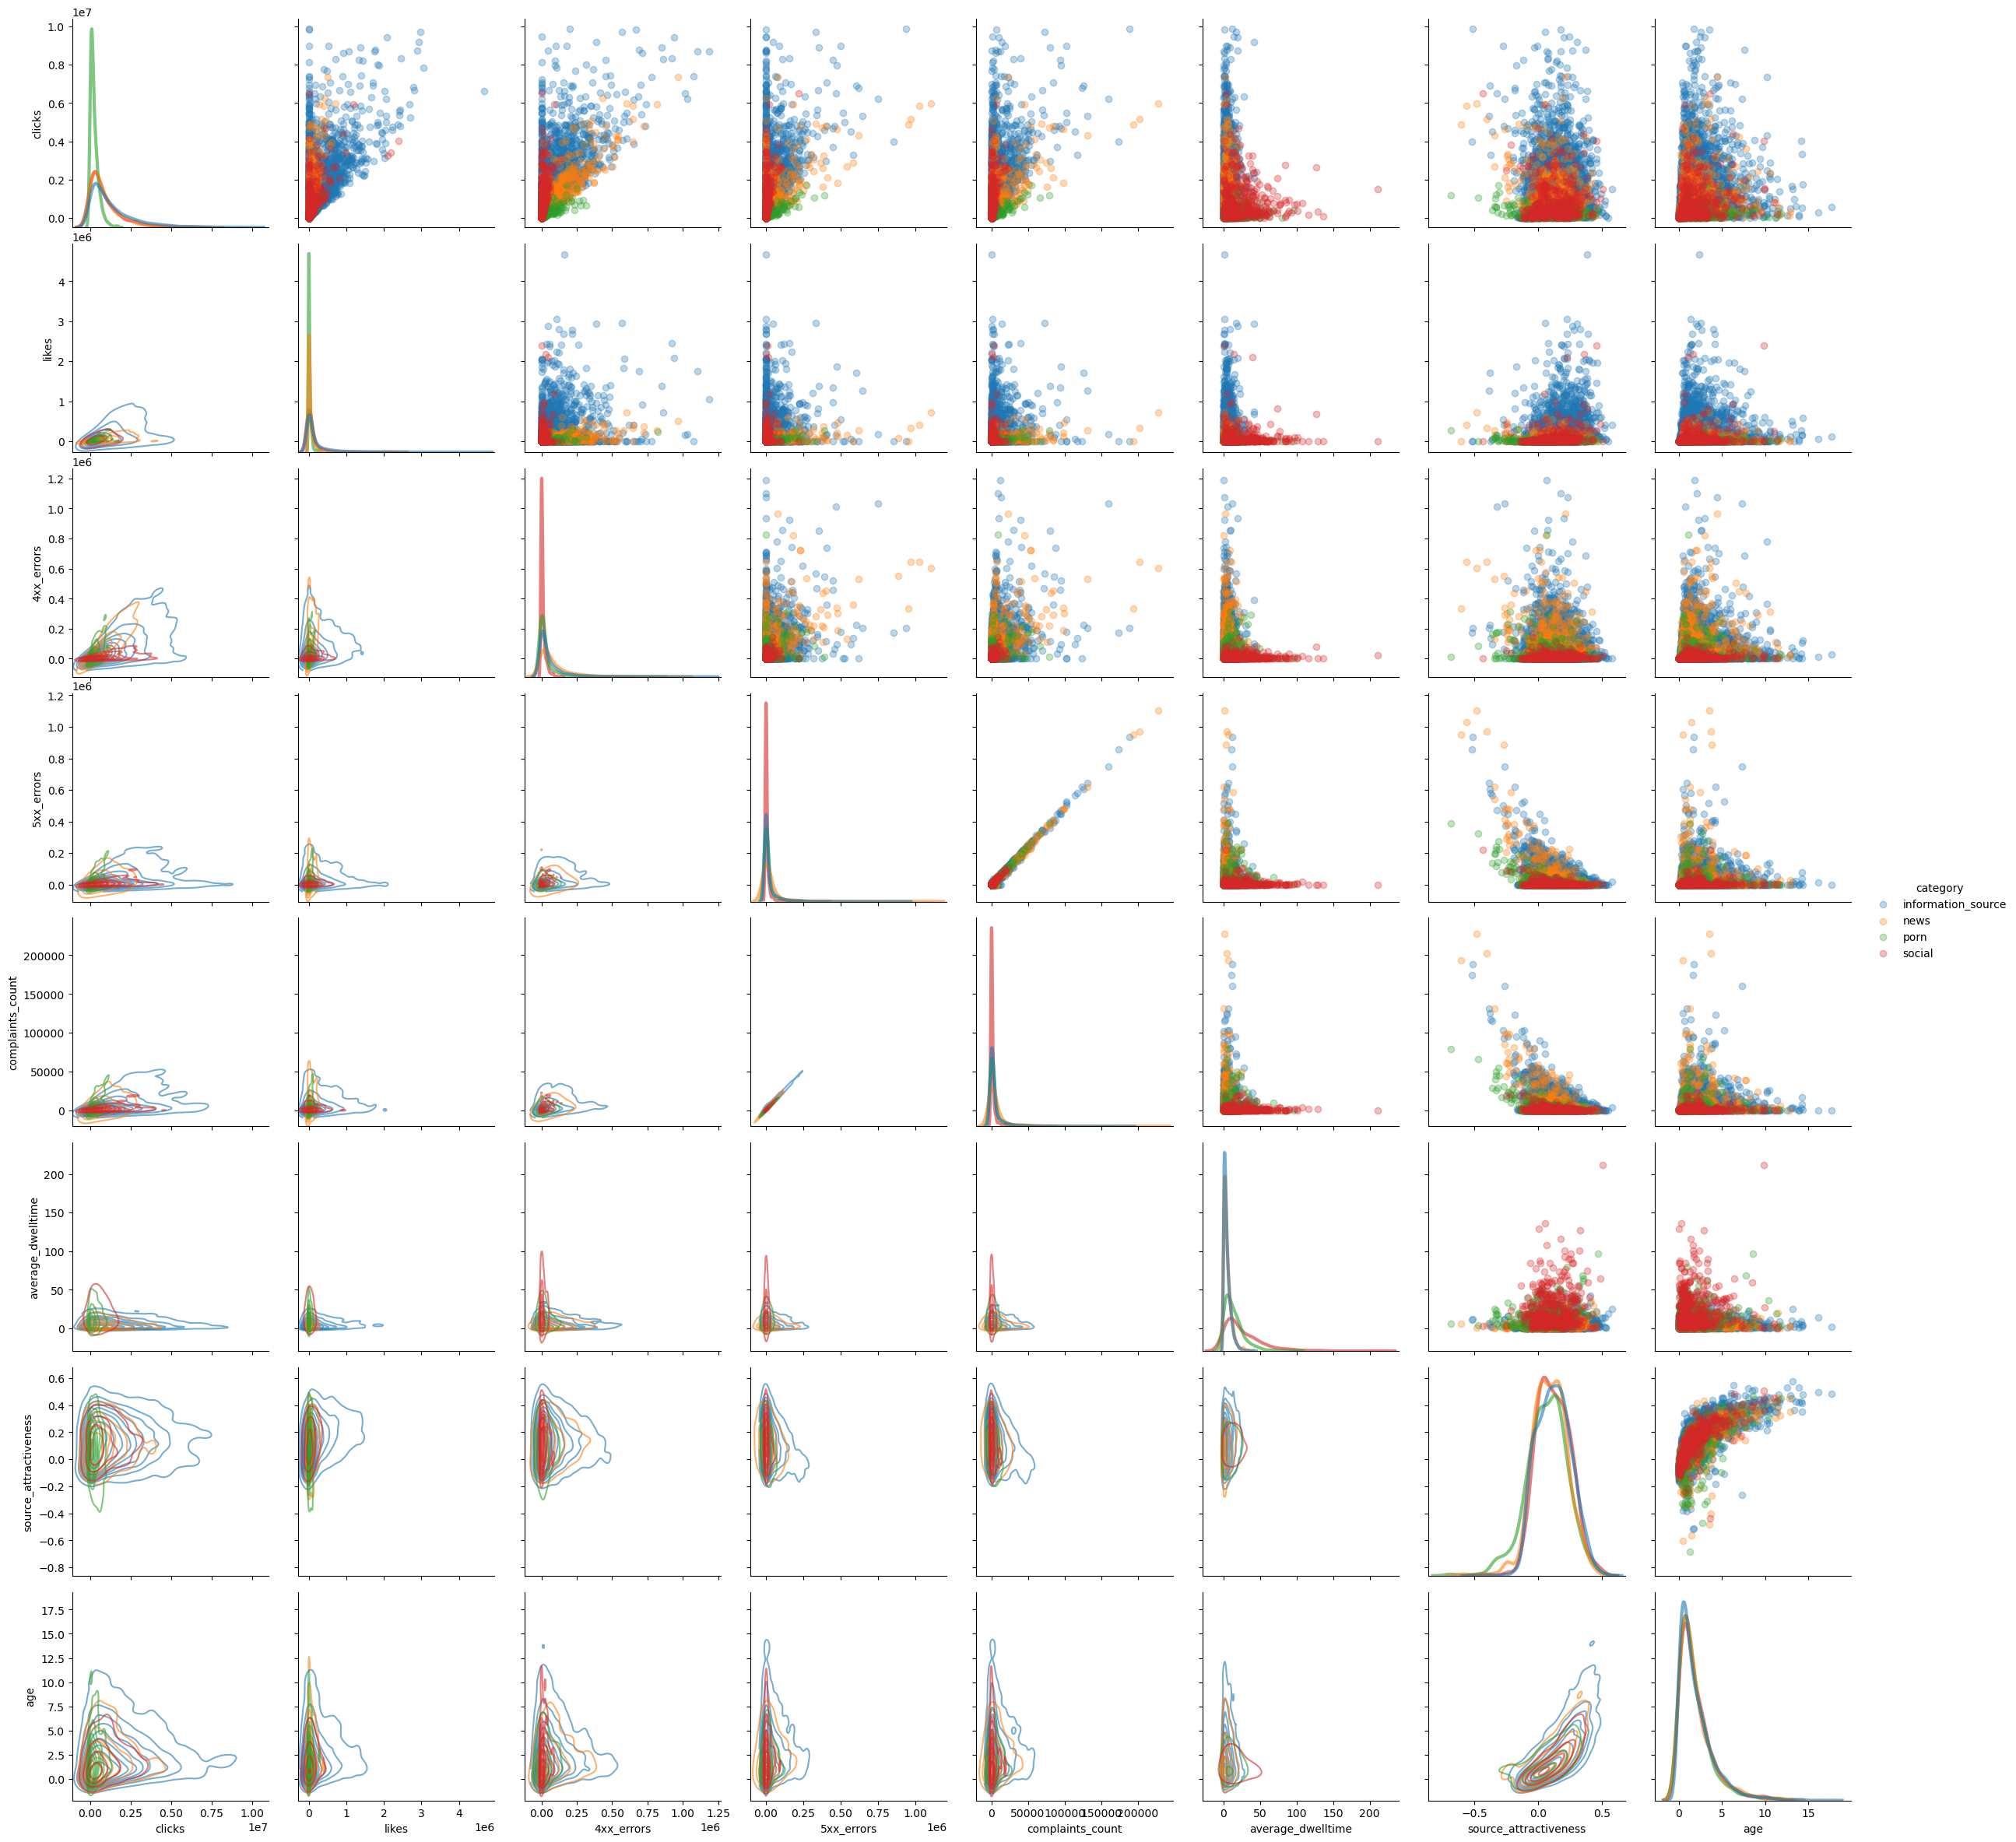

In [36]:
g = sns.PairGrid(other_domains.drop(columns=categorial_features), hue='category', diag_sharey=False, height=3)
g.map_lower(sns.kdeplot, alpha=0.6)
g.map_upper(plt.scatter, alpha=0.3)
g.map_diag(sns.kdeplot, lw=3, alpha=0.6, common_norm=False)
g.add_legend()
plt.show()

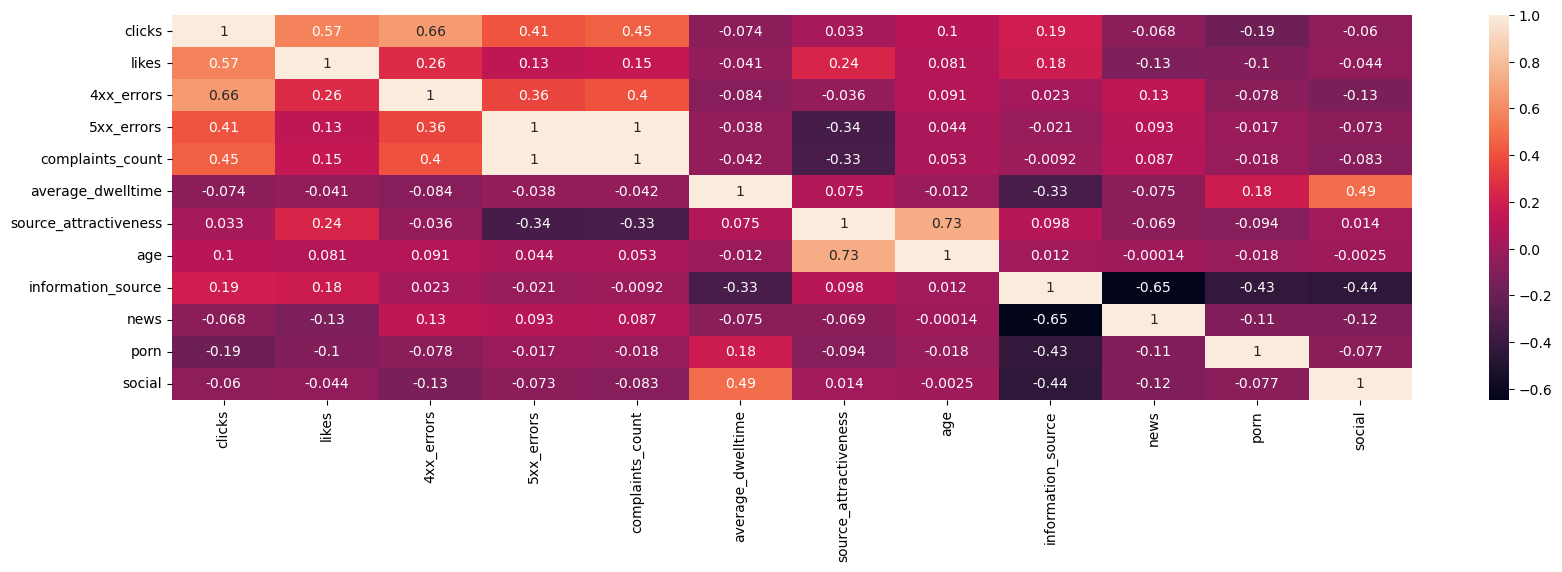

In [96]:
corr_matrix = other_domains.drop('category', axis=1).corr()
plt.figure(figsize=(20, 5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [97]:
inf_source = other_domains[other_domains['information_source'] == 1].drop(columns=[*categorial_features, 'category'])
other_domains = other_domains[other_domains['information_source'] == 0].drop(columns=['information_source'])


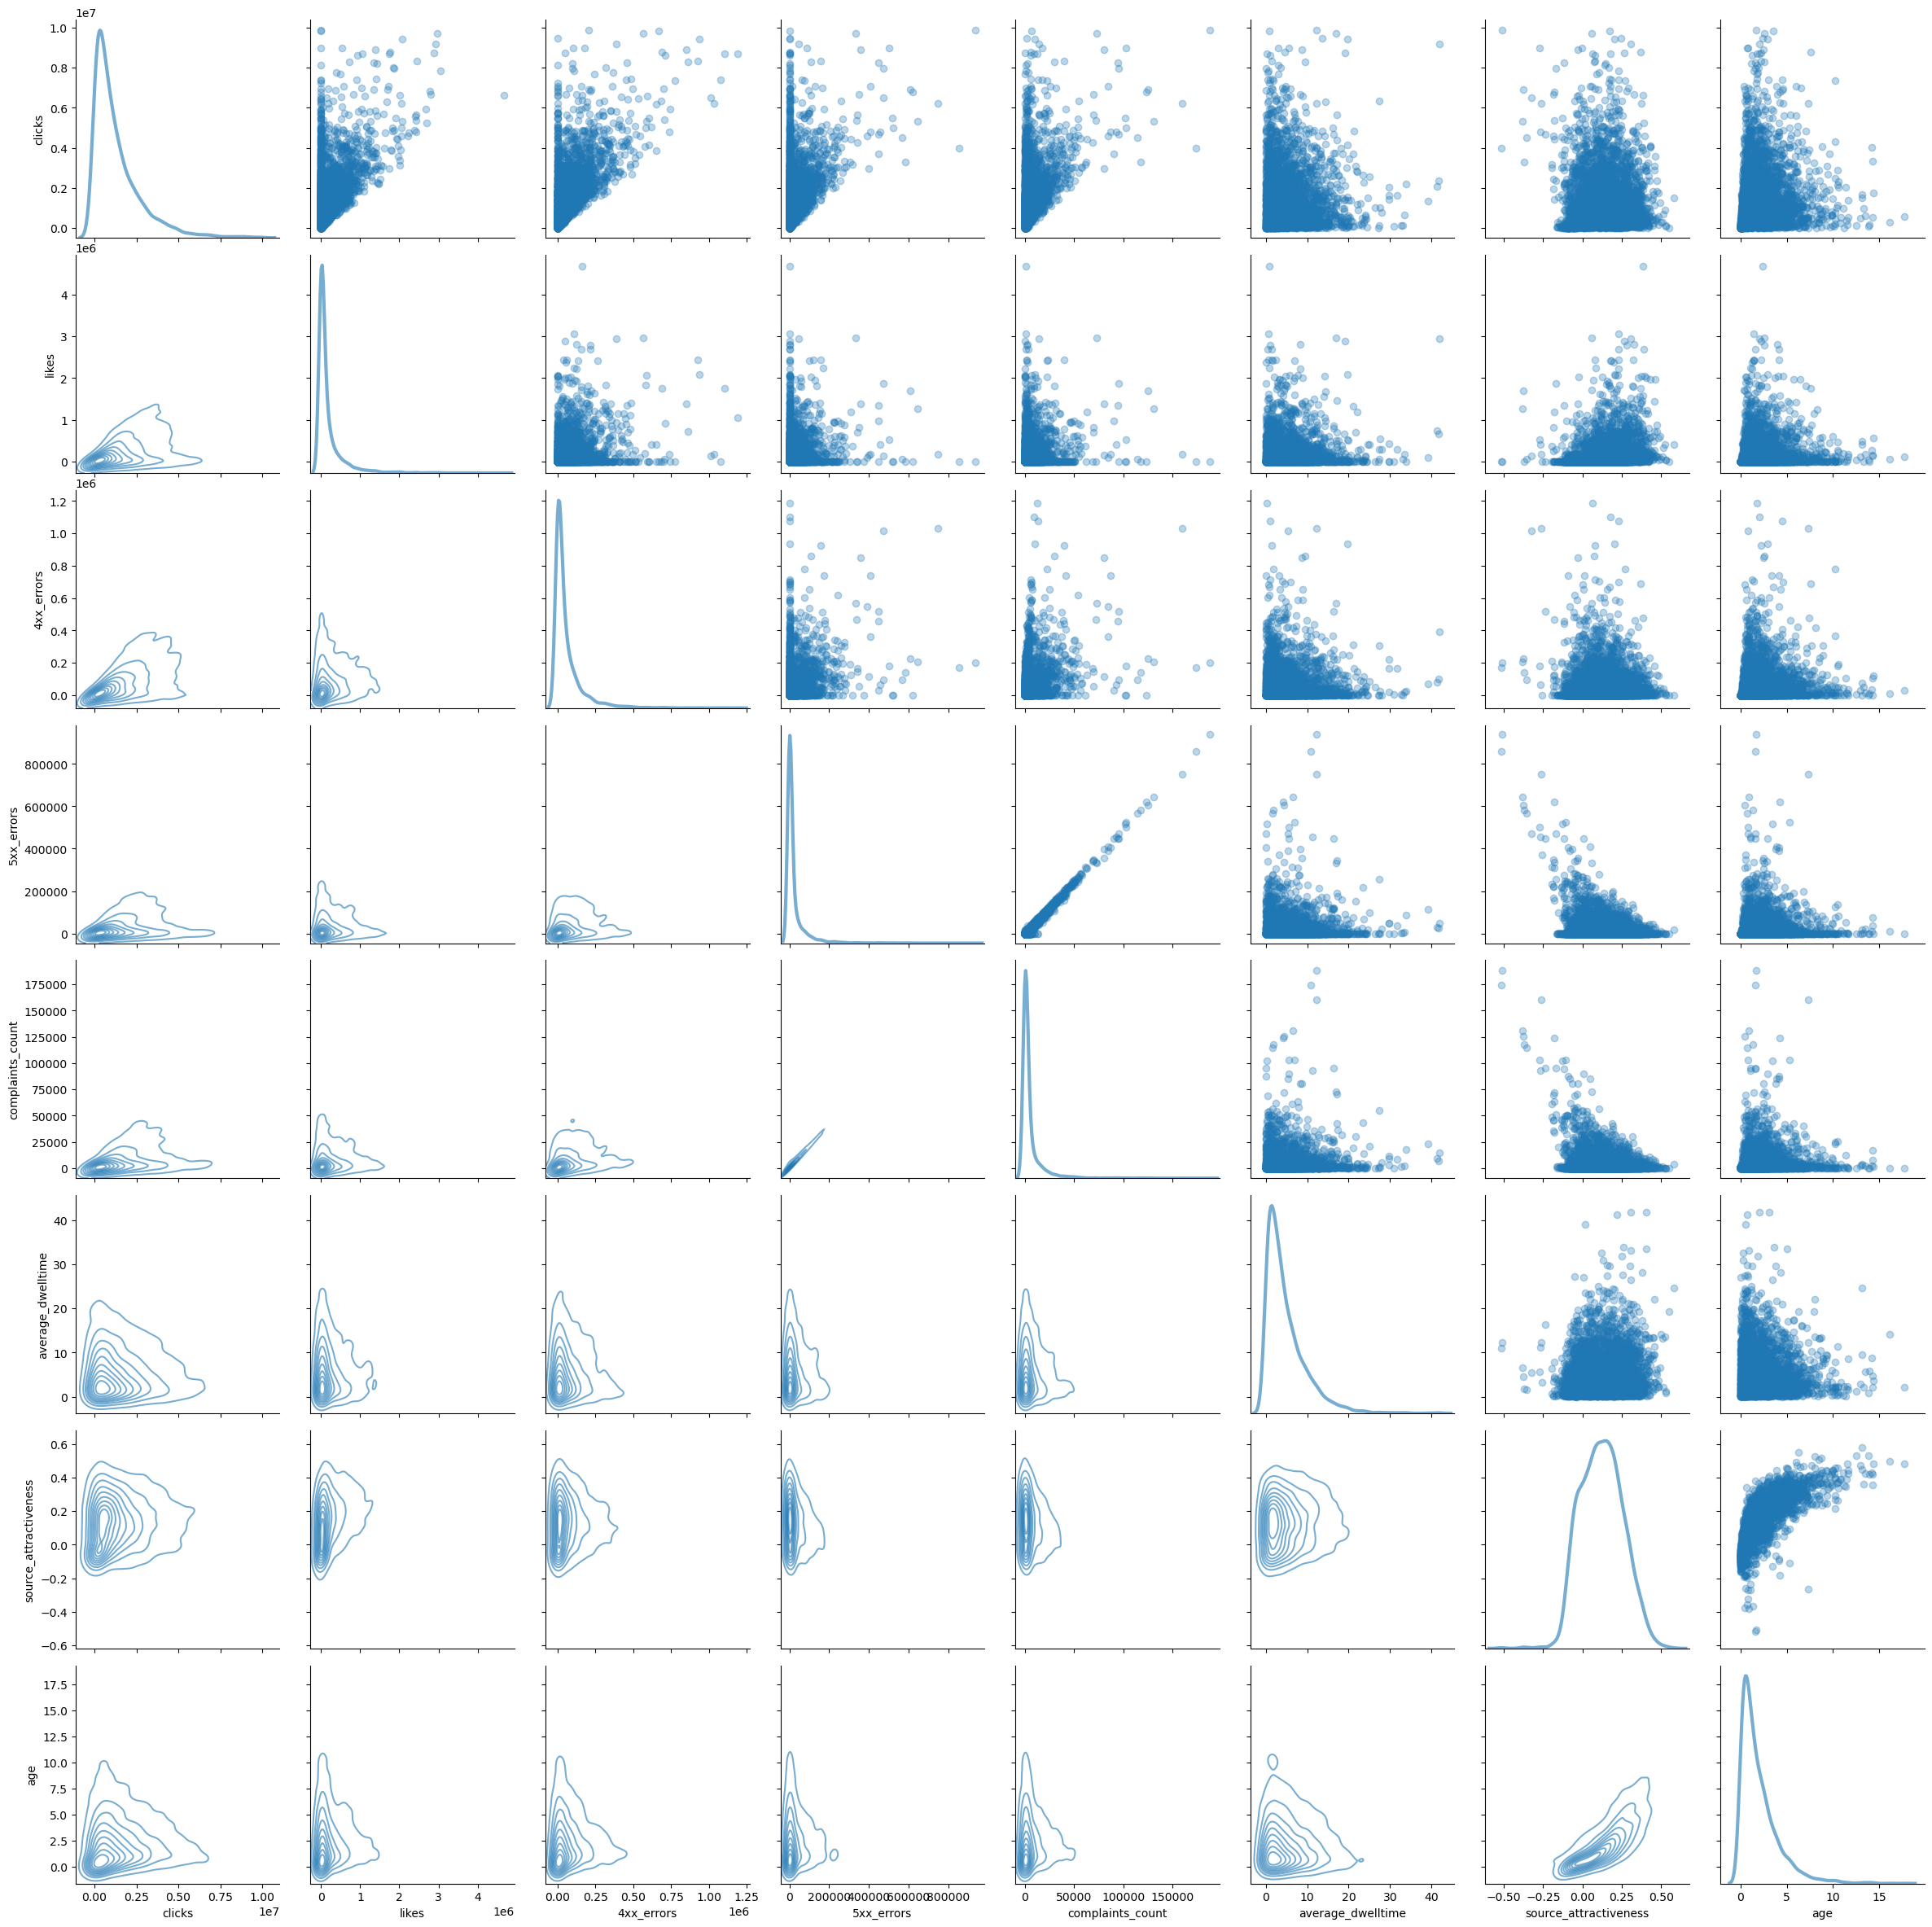

In [44]:
g = sns.PairGrid(inf_source, diag_sharey=False, height=3)
g.map_lower(sns.kdeplot, alpha=0.6)
g.map_upper(plt.scatter, alpha=0.3)
g.map_diag(sns.kdeplot, lw=3, alpha=0.6, common_norm=False)
plt.show()

In [98]:
for i in inf_source.drop(columns=[target, 'age', 'average_dwelltime']):
    inf_source[f'{i}_per_year'] = get_per_year(inf_source, i)
    inf_source[f'{i}_per_click'] = get_per_click(inf_source, i)
    inf_source[f'{i}_per_dwelltime'] = get_per_dwelltime(inf_source, i)

In [100]:
inf_source = inf_source.drop(columns='clicks_per_click')    

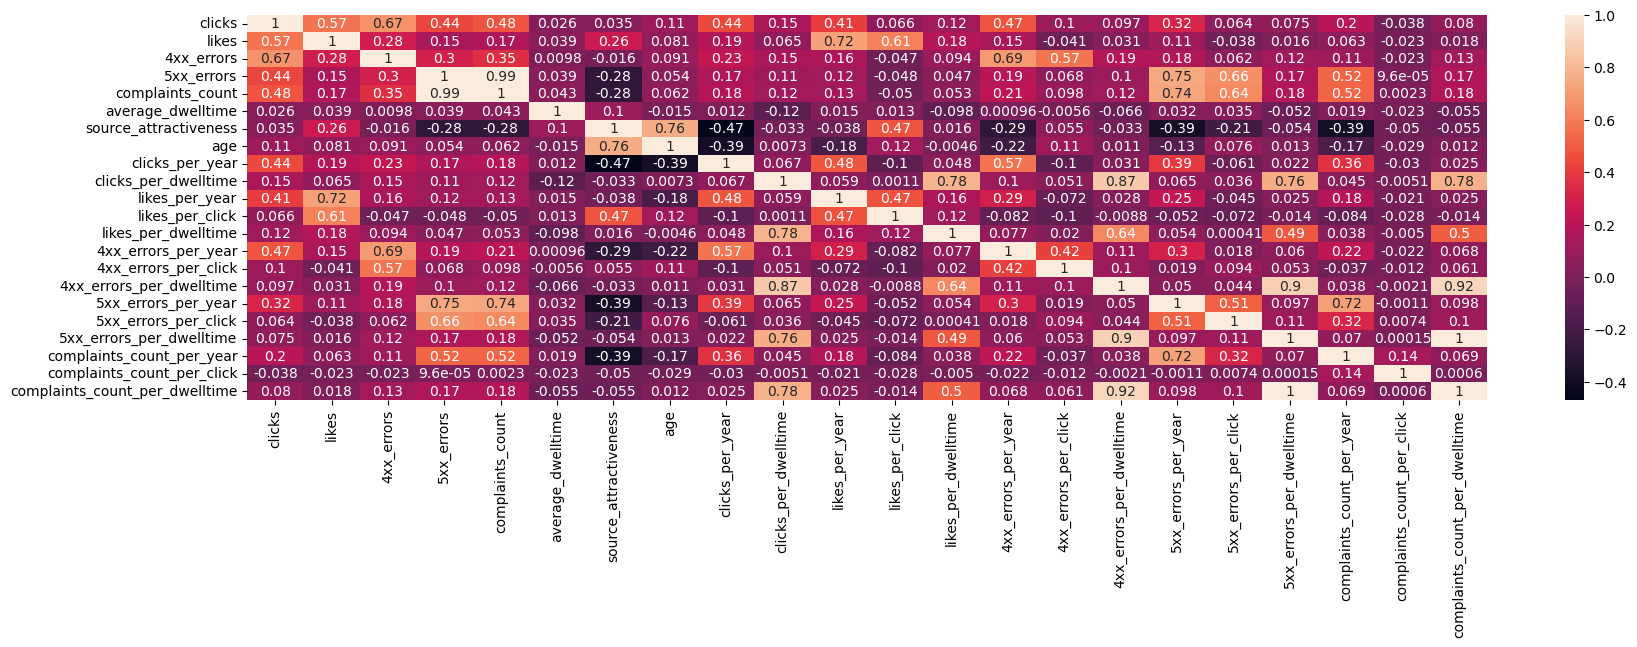

In [101]:
corr_matrix = inf_source.corr()
plt.figure(figsize=(20, 5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [102]:
categorial_features = categorial_features[1:]

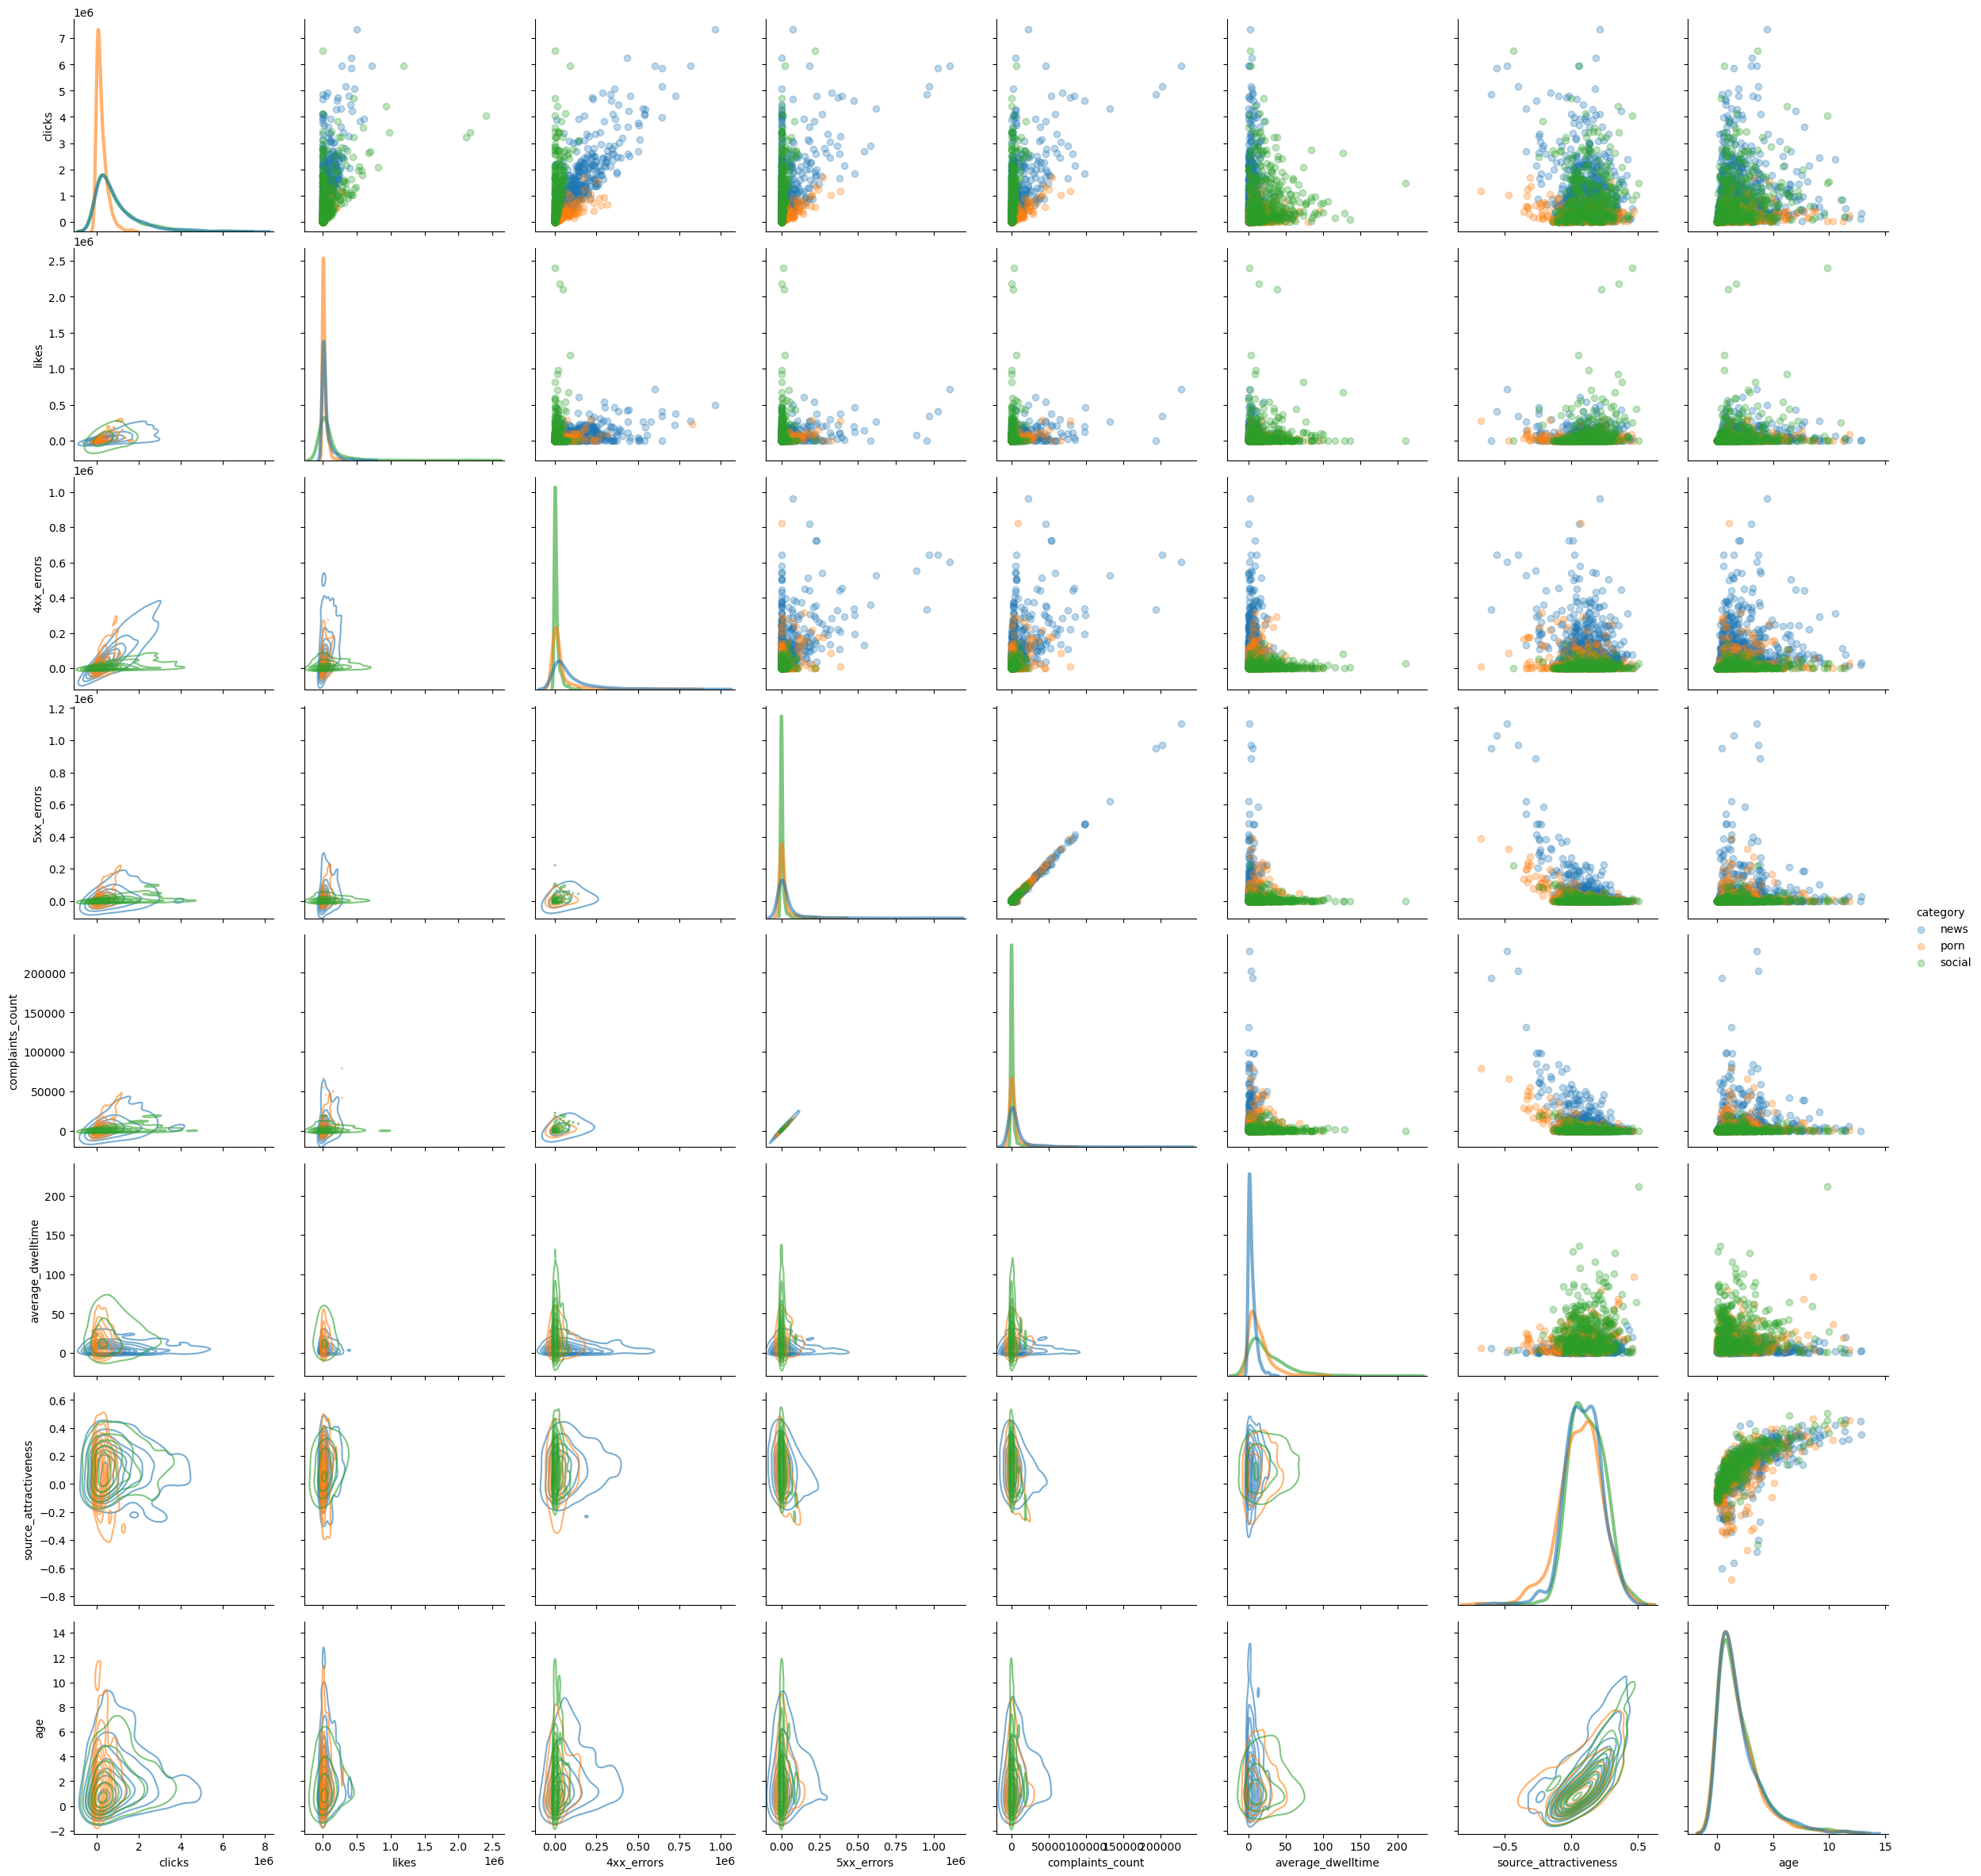

In [47]:
g = sns.PairGrid(other_domains.drop(columns=categorial_features), hue='category', diag_sharey=False, height=3)
g.map_lower(sns.kdeplot, alpha=0.6)
g.map_upper(plt.scatter, alpha=0.3)
g.map_diag(sns.kdeplot, lw=3, alpha=0.6, common_norm=False)
g.add_legend()
plt.show()

In [104]:
for i in other_domains.drop(columns=[target, *categorial_features, 'category', 'age', 'average_dwelltime']):
    other_domains[f'{i}_per_year'] = get_per_year(other_domains, i)
    other_domains[f'{i}_per_click'] = get_per_click(other_domains, i)
    other_domains[f'{i}_per_dwelltime'] = get_per_dwelltime(other_domains, i)

other_domains = other_domains.drop(columns='clicks_per_click')

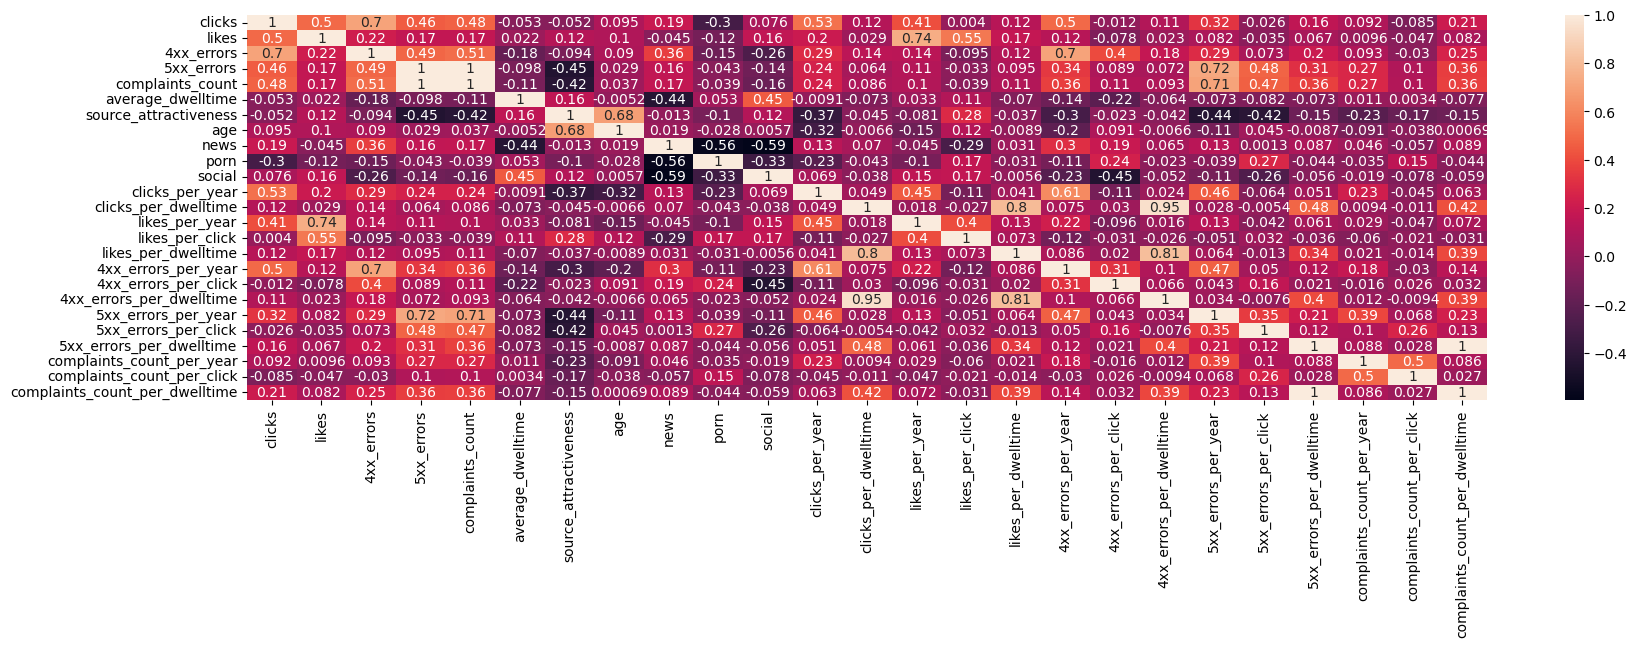

In [105]:
corr_matrix = other_domains.drop('category', axis=1).corr()
plt.figure(figsize=(20, 5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [63]:
d = dict(other_domains[['clicks', 'category']].groupby('category').median()['clicks'])
domains['d'] = d[domains['category']]

TypeError: unhashable type: 'Series'

Так как complaints_count и 5xx_errors линейно зависимы, и complaints_count содержит пропуски, удалим этот столбец из датафрейма

In [ ]:
domains = domains.drop('complaints_count', axis=1)
real_features.remove('complaints_count')

Так как average_dwelltime по разному коррелирует с разными категориями сайтов, заполним пропуски, медианными для каждой категории значениями

In [ ]:
mean_dwelltime = domains[['category', 'average_dwelltime']].groupby('category')['average_dwelltime'].median()
mean_dwelltime

In [ ]:
domains['average_dwelltime'] = domains.apply(lambda row: row['average_dwelltime'] if not np.isnan(row['average_dwelltime']) else mean_dwelltime[row['category']], axis=1)
domains['average_dwelltime'].hist(bins=100)
plt.show()

С лайками поступим так же

In [ ]:
mean_likes = domains[['category', 'likes']].groupby('category')['likes'].median()
mean_likes

In [ ]:
domains['likes'] = domains.apply(lambda row: row['likes'] if not np.isnan(row['likes']) else mean_dwelltime[row['category']], axis=1)
domains['likes'].hist(bins=100)
plt.show()

Так как много признаков имеет высокий коэффициент корреляции с clicks, для clicks заполнения пропусков в clicks можно использовать линейную модель

In [ ]:
corr_matrix = domains.drop('category', axis=1).corr()
plt.figure(figsize=(20, 5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
clicks_data = domains.drop(columns=['category', 'source_attractiveness', 'average_dwelltime', 'social'])
X_clicks = clicks_data[clicks_data['clicks'].notna()].drop(columns='clicks')
Y_clicks = clicks_data[clicks_data['clicks'].notna()]['clicks']
X_train, X_test, Y_train, Y_test = train_test_split(X_clicks, Y_clicks, test_size=0.2)
clicks_data.info()

In [ ]:
clicks_data_scaler = StandardScaler()

X_train = clicks_data_scaler.fit_transform(X_train)
X_test = clicks_data_scaler.transform(X_test)

poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [ ]:
alphas = np.logspace(-1, 10)
l1_ratio = np.logspace(-1, 0)
alphas

In [ ]:
clicks_model = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas)

clicks_model.fit(X_train, Y_train)

print("Optimal Alpha:", clicks_model.alpha_)
print("Optimal L1 Ratio:", clicks_model.l1_ratio_)


Y_pred = clicks_model.predict(X_test)
print("R-squared score:", r2_score(Y_test, Y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("MAPE:", mean_absolute_percentage_error(Y_test, Y_pred))
clicks_model.coef_

In [ ]:
X = domains[domains['clicks'].isna()].drop(columns=['category', 'source_attractiveness', 'clicks', 'average_dwelltime', 'social'])
X = poly.transform(X)
Y = clicks_model.predict(X)

nan_clicks = domains['clicks'].isna()
domains.loc[nan_clicks, 'clicks'] = Y

corr_matrix = domains.drop('category', axis=1).corr()
plt.figure(figsize=(20, 5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
Y = domains['source_attractiveness']
X = domains.drop(columns=['category', 'social', 'source_attractiveness'])
domains_scaler = StandardScaler()
X = domains_scaler.fit_transform(X)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
model = ElasticNetCV(cv=5)
scores = cross_val_score(model, X, Y, scoring=make_scorer(mean_squared_error), cv=cv.split(X))
scores